In [1]:
import numpy as np
import pandas as pd
import numpy.random as npr
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
import timeit

2023-12-19 14:17:55.433034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Dataset

In [2]:
#importing Part A LOB Data
df = pd.read_csv('Data_A.csv', header=None)
df.columns =  ['label', 'SP1 (ask)', 'SV1', 'BP1 (bid)', 'BV1', 'SP2', 'SV2','BP2',
               'BV2', 'SP3', 'SV3', 'BP3', 'BV3', 'SP4','SV4', 'BP4', 'BV4', 'c_-5',
               'c_-4', 'c_-3', 'c_-2', 'c_-1']


In [3]:
#normalise the first 16 features

df.iloc[:, 1:17] = StandardScaler().fit_transform(df.iloc[:, 1:17])


Storing our train/validate/test split datasets.

In [4]:
#training/validation/test split; using a 80/10/10 split

#separate training into features and labels
df_training = df.sample(frac = 0.8)
training_data = df_training.drop(columns = ['label'])
training_labels = df_training['label']

#separate validation into features and labels
df_validate = df.drop(df_training.index).sample(frac = 0.5)
validate_data = df_validate.drop(columns = ['label'])
validate_labels = df_validate['label']

#separate validation into features and labels
df_test = df.drop(df_training.index).drop(df_validate.index)
test_data = df_test.drop(columns = ['label'])
test_labels = df_test['label']

print("Training Shape:",np.shape(training_data))
print("Validation Shape:",np.shape(validate_data))
print("Testing Shape:",np.shape(test_data))
print("Number of Features: ",training_data.shape[1])

Training Shape: (160000, 21)
Validation Shape: (20000, 21)
Testing Shape: (20000, 21)
Number of Features:  21


## Model(s) Construction

Initialising all model variations to be used for testing later on and also the true FNN that we want to use. i.e.

1) model_DP which is the main FNN we look to implement- trained using Adam with 0.2 Dropout rate
2) model_noDP which is trained using Adam and includes no Dropout Layers
3) model_SGD which is trained using SGD and includes Dropout layers
4) model_leaky which is trained using Adam but now uses leaky ReLU activations in place of ReLU

We implement 2)-4) to compare with 1) which is our main FNN. 

#### Therefore, we will compare and optimise our model in regards to usage of dropout layers, optimisers, and choice of activations.

In [5]:
#main model - Adam(0.001), ReLU, Dropout(0.2)
model_DP = keras.Sequential([
    keras.layers.InputLayer(input_shape=(training_data.shape[1]),),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
]
)

#alternative model - Adam(0.001), ReLU, no Dropout
model_noDP = keras.Sequential([
    keras.layers.InputLayer(input_shape=(training_data.shape[1]),),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
]
)

#alternative model - SGD(0.001), ReLU, Dropout(0.2)
model_SGD = keras.Sequential([
    keras.layers.InputLayer(input_shape=(training_data.shape[1]),),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
]
)

#alternative model - Adam(0.001), leakyReLU(0.01) , Dropout(0.2)
model_leaky = keras.Sequential([
    keras.layers.InputLayer(input_shape=(training_data.shape[1]),),
    keras.layers.Dense(50, activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(50, activation=keras.layers.LeakyReLU(alpha=0.01)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
]
)

#### We will first compare these models by calibration time and fit them in the process using our training and validation data.

Starting with the fitting of our main model

In [6]:
#binary cross entropy for classification

#choosing relatively small eta for best fit / training speed
eta = 0.001

#epochs and batch size
ep = 40
batch = 200

#compile + train main model
start_time = timeit.default_timer()
model_DP.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), loss="binary_crossentropy", metrics=["accuracy"])
history_DP = model_DP.fit(training_data, training_labels, batch_size=batch, epochs=ep,
                          validation_data=(validate_data,validate_labels), verbose=0)
elapsed_DP = timeit.default_timer() - start_time
elapsed_DP = np.round(elapsed_DP,2)

loss_DP = history_DP.history["loss"]
val_loss_DP = history_DP.history["val_loss"]


Now initialising a few model variants for comparison

In [7]:
#compiling and training alternative models

start_time = timeit.default_timer()
model_noDP.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), loss="binary_crossentropy", metrics=["accuracy"])
history_noDP = model_noDP.fit(training_data, training_labels, batch_size=batch, epochs=ep,
                              validation_data=(validate_data,validate_labels), verbose=0)
elapsed_noDP = timeit.default_timer() - start_time
elapsed_noDP = np.round(elapsed_noDP,2)

start_time = timeit.default_timer()
model_SGD.compile(optimizer=keras.optimizers.SGD(learning_rate=eta), loss="binary_crossentropy", metrics=["accuracy"])
history_SGD = model_SGD.fit(training_data, training_labels, batch_size=batch, epochs=ep,
                            validation_data=(validate_data,validate_labels), verbose=0)
elapsed_SGD = timeit.default_timer() - start_time
elapsed_SGD = np.round(elapsed_SGD,2)

start_time = timeit.default_timer()
model_leaky.compile(optimizer=keras.optimizers.Adam(learning_rate=eta), loss="binary_crossentropy", metrics=["accuracy"])
history_leaky = model_leaky.fit(training_data, training_labels, batch_size=batch, epochs=ep,
                                validation_data=(validate_data,validate_labels), verbose=0)
elapsed_leaky = timeit.default_timer() - start_time
elapsed_leaky = np.round(elapsed_SGD,2)

loss_noDP = history_noDP.history["loss"]
val_loss_noDP = history_noDP.history["val_loss"]

loss_SGD = history_SGD.history["loss"]
val_loss_SGD = history_SGD.history["val_loss"]

loss_leaky = history_leaky.history["loss"]
val_loss_leaky = history_leaky.history["val_loss"]


In [8]:
#looking at time taken for each model to calibrate

time_df = pd.DataFrame([[elapsed_DP],[elapsed_noDP],[elapsed_SGD], [elapsed_leaky]], columns = ['Time Taken (s)'],
                       index = ['Dropout (Adam)', 'No Dropout (Adam)', 'SGD (Dropout)', 'Leaky ReLU (0.01)'])

display(time_df)

,Time Taken (s)
Dropout (Adam),35.92
No Dropout (Adam),31.60
SGD (Dropout),33.95
Leaky ReLU (0.01),33.95


#### Now can visualise training loss and validation loss as a way to compare the fit for our different model variations.

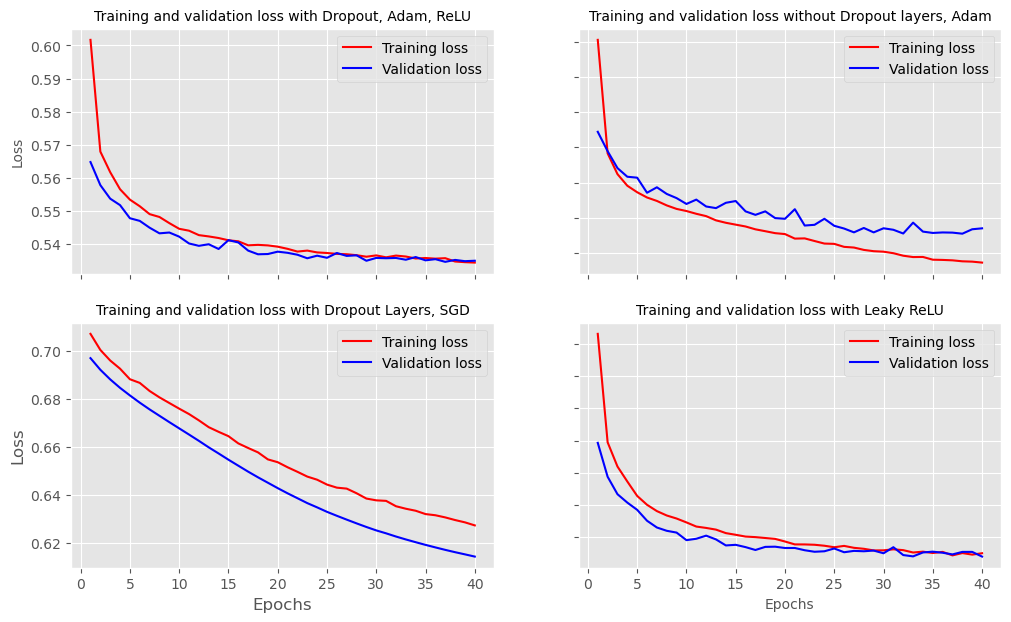

In [9]:
#visualising the losses vs validated losses for our models

epochs = range(1,len(loss_DP)+1)

fig , axs = plt.subplots(2,2,figsize=(12,7))

axs[0,0].plot(epochs, loss_DP, "r", label="Training loss")
axs[0,0].plot(epochs, val_loss_DP, "b", label="Validation loss")
axs[0,0].set_title("Training and validation loss with Dropout, Adam, ReLU", fontsize=10)
axs[0,0].set_xlabel("Epochs", fontsize=10)
axs[0,0].set_ylabel("Loss", fontsize=10)
axs[0,0].legend()

axs[0,1].plot(epochs, loss_noDP, "r", label="Training loss")
axs[0,1].plot(epochs, val_loss_noDP, "b", label="Validation loss")
axs[0,1].set_title("Training and validation loss without Dropout layers, Adam", fontsize=10)
axs[0,1].set_xlabel("Epochs", fontsize=10)
axs[0,1].set_ylabel("Loss", fontsize=10)
axs[0,1].legend()


axs[1,0].plot(epochs, loss_SGD, "r", label="Training loss")
axs[1,0].plot(epochs, val_loss_SGD, "b", label="Validation loss")
axs[1,0].set_title("Training and validation loss with Dropout Layers, SGD", fontsize=10)
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("Loss")
axs[1,0].legend()


axs[1,1].plot(epochs, loss_leaky, "r", label="Training loss")
axs[1,1].plot(epochs, val_loss_leaky, "b", label="Validation loss")
axs[1,1].set_title("Training and validation loss with Leaky ReLU", fontsize=10)
axs[1,1].set_xlabel("Epochs", fontsize=10)
axs[1,1].set_ylabel("Loss", fontsize=10)
axs[1,1].legend()

for ax in axs.flat:
    ax.label_outer()

plt.show()


## Testing

Now with our trained models can again compare accuracy with test data to again see if our chosen model is optimal.

In [10]:
#predicting test set and comparing accuracy and st. dev with each model

forecasts_DP = model_DP.predict(test_data, verbose=0)
forecasts_DP = np.concatenate(forecasts_DP, axis = 0)
forecasts_DP = np.round(forecasts_DP)
acc_DP = np.sum(forecasts_DP == test_labels)/len(forecasts_DP)
acc_DP = np.round(acc_DP*100 , 2)
std_DP = np.round(np.std(forecasts_DP == test_labels),2)

forecasts_noDP = model_noDP.predict(test_data, verbose=0)
forecasts_noDP = np.concatenate(forecasts_noDP, axis = 0)
forecasts_noDP = np.round(forecasts_noDP)
acc_noDP = np.sum(forecasts_noDP == test_labels)/len(forecasts_noDP)
acc_noDP = np.round(acc_noDP*100 , 2)
std_noDP = np.round(np.std(forecasts_noDP == test_labels),2)

forecasts_SGD = model_SGD.predict(test_data, verbose=0)
forecasts_SGD = np.concatenate(forecasts_SGD, axis = 0)
forecasts_SGD = np.round(forecasts_SGD)
acc_SGD = np.sum(forecasts_SGD == test_labels)/len(forecasts_SGD)
acc_SGD = np.round(acc_SGD*100 , 2)
std_SGD = np.round(np.std(forecasts_SGD == test_labels),2)

forecasts_leaky = model_leaky.predict(test_data, verbose=0)
forecasts_leaky = np.concatenate(forecasts_leaky, axis = 0)
forecasts_leaky = np.round(forecasts_leaky)
acc_leaky = np.sum(forecasts_leaky == test_labels)/len(forecasts_leaky)
acc_leaky = np.round(acc_leaky*100 , 2)
std_leaky = np.round(np.std(forecasts_leaky == test_labels),2)


In [11]:
#looking at test results for each model variation

acc_df = pd.DataFrame([[acc_DP,std_DP],[acc_noDP,std_noDP],[acc_SGD,std_SGD], [acc_leaky,std_leaky]],
                       columns = ['Accuracy(%)','Standard Error'],
                       index = ['Dropout (Adam)', 'No Dropout (Adam)', 'SGD (Dropout)', 'Leaky ReLU (0.01)'])

display(acc_df)

,Accuracy(%),Standard Error
Dropout (Adam),72.09,0.45
No Dropout (Adam),71.76,0.45
SGD (Dropout),65.94,0.47
Leaky ReLU (0.01),71.81,0.45


## Part B- Making Predictions for Dataset B

In [12]:
#making datset 2 forecasts
df_B = pd.read_csv('Data_B_nolabels.csv', header=None)

#normalise the features
df_B.iloc[:, :17] = StandardScaler().fit_transform(df_B.iloc[:, :17])

#make forecast
forecasts_B = model_DP.predict(df_B, verbose=0)
forecasts_B = np.concatenate(forecasts_B, axis = 0)
forecasts_B = np.round(forecasts_B)
forecasts_B = [int(x) for x in forecasts_B]

#store as txt
df_forecasts = pd.DataFrame(forecasts_B, columns = [''] , index = ['']*len(forecasts_B))
df_forecasts.to_csv('Predictions.txt', sep='\t', index = False, header=None)